1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?

- 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.

2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?

- 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.

3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?

- 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

# Step1. 검증용 데이터셋 준비
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.


-------------------------------------

손글씨를 인식하여 
1. 맹인이나 눈이 안 좋은 이들, 문맹자에게 손글씨 편지를 음성으로 읽어주어 편지를 읽어줄 수 있다.
2. 키보드에 익숙하지 않은, 디지털 역량이 떨어지는 자들의 손글씨로 쓴 글을 디지털로 문서화할 수 있다.
3. 학생들이 필기한 노트를 인식, 업로드하여 쉽게 파일로 저장할 수 있다.


# Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

# 1. Google OCR API

In [1]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [27]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# for문이 왜 안돌까? 
'''
# 입력 이미지 경로를 지정해 주세요.
for image in range(1,3):
    path = os.getenv('HOME')+'/aiffel/ocr_python/handwriting_Kor'
    f'path/{image}.*'
    detect_text(image)
'''
image = os.getenv('HOME')+'/aiffel/ocr_python/handwriting_Kor/1.jpg'
detect_text(image)
# path = # [[YOUR IMAGE FILE PATH]]   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
    

-rw-rw-r-- 1 aiffel aiffel 2325 Mar 18 16:43 /home/aiffel/aiffel/ocr_python/my_google_api_key.json
Texts:

"네이버 클로바와 함께하는
한글한글 아름답게 캠페인 나눔손글씨
앞으로 쓰여질 우리의 이야기를 응원합니다.
"

"네이버"

"클로바"

"와"

"함께하는"

"한글"

"한글"

"아름답게"

"캠페인"

"나눔"

"손글씨"

"앞으로"

"쓰여질"

"우리"

"의"

"이야기"

"를"

"응원"

"합니다"

"."
bounds: (636,167),(656,167),(656,195),(636,195)


# 2. Keras-ocr

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel/.keras-ocr/crnn_kurapan.h5


In [41]:
img_ker = ['/home/aiffel/aiffel/ocr_python/handwriting_Eng/1.jpg',
    '/home/aiffel/aiffel/ocr_python/handwriting_Eng/2.jpg',
    '/home/aiffel/aiffel/ocr_python/handwriting_Eng/3.jpg',
    '/home/aiffel/aiffel/ocr_python/handwriting_Eng/4.jpg' 
]


imgs = [keras_ocr.tools.read(img) for img in img_ker]
pred = [pipeline.recognize([img])for img in img_ker]

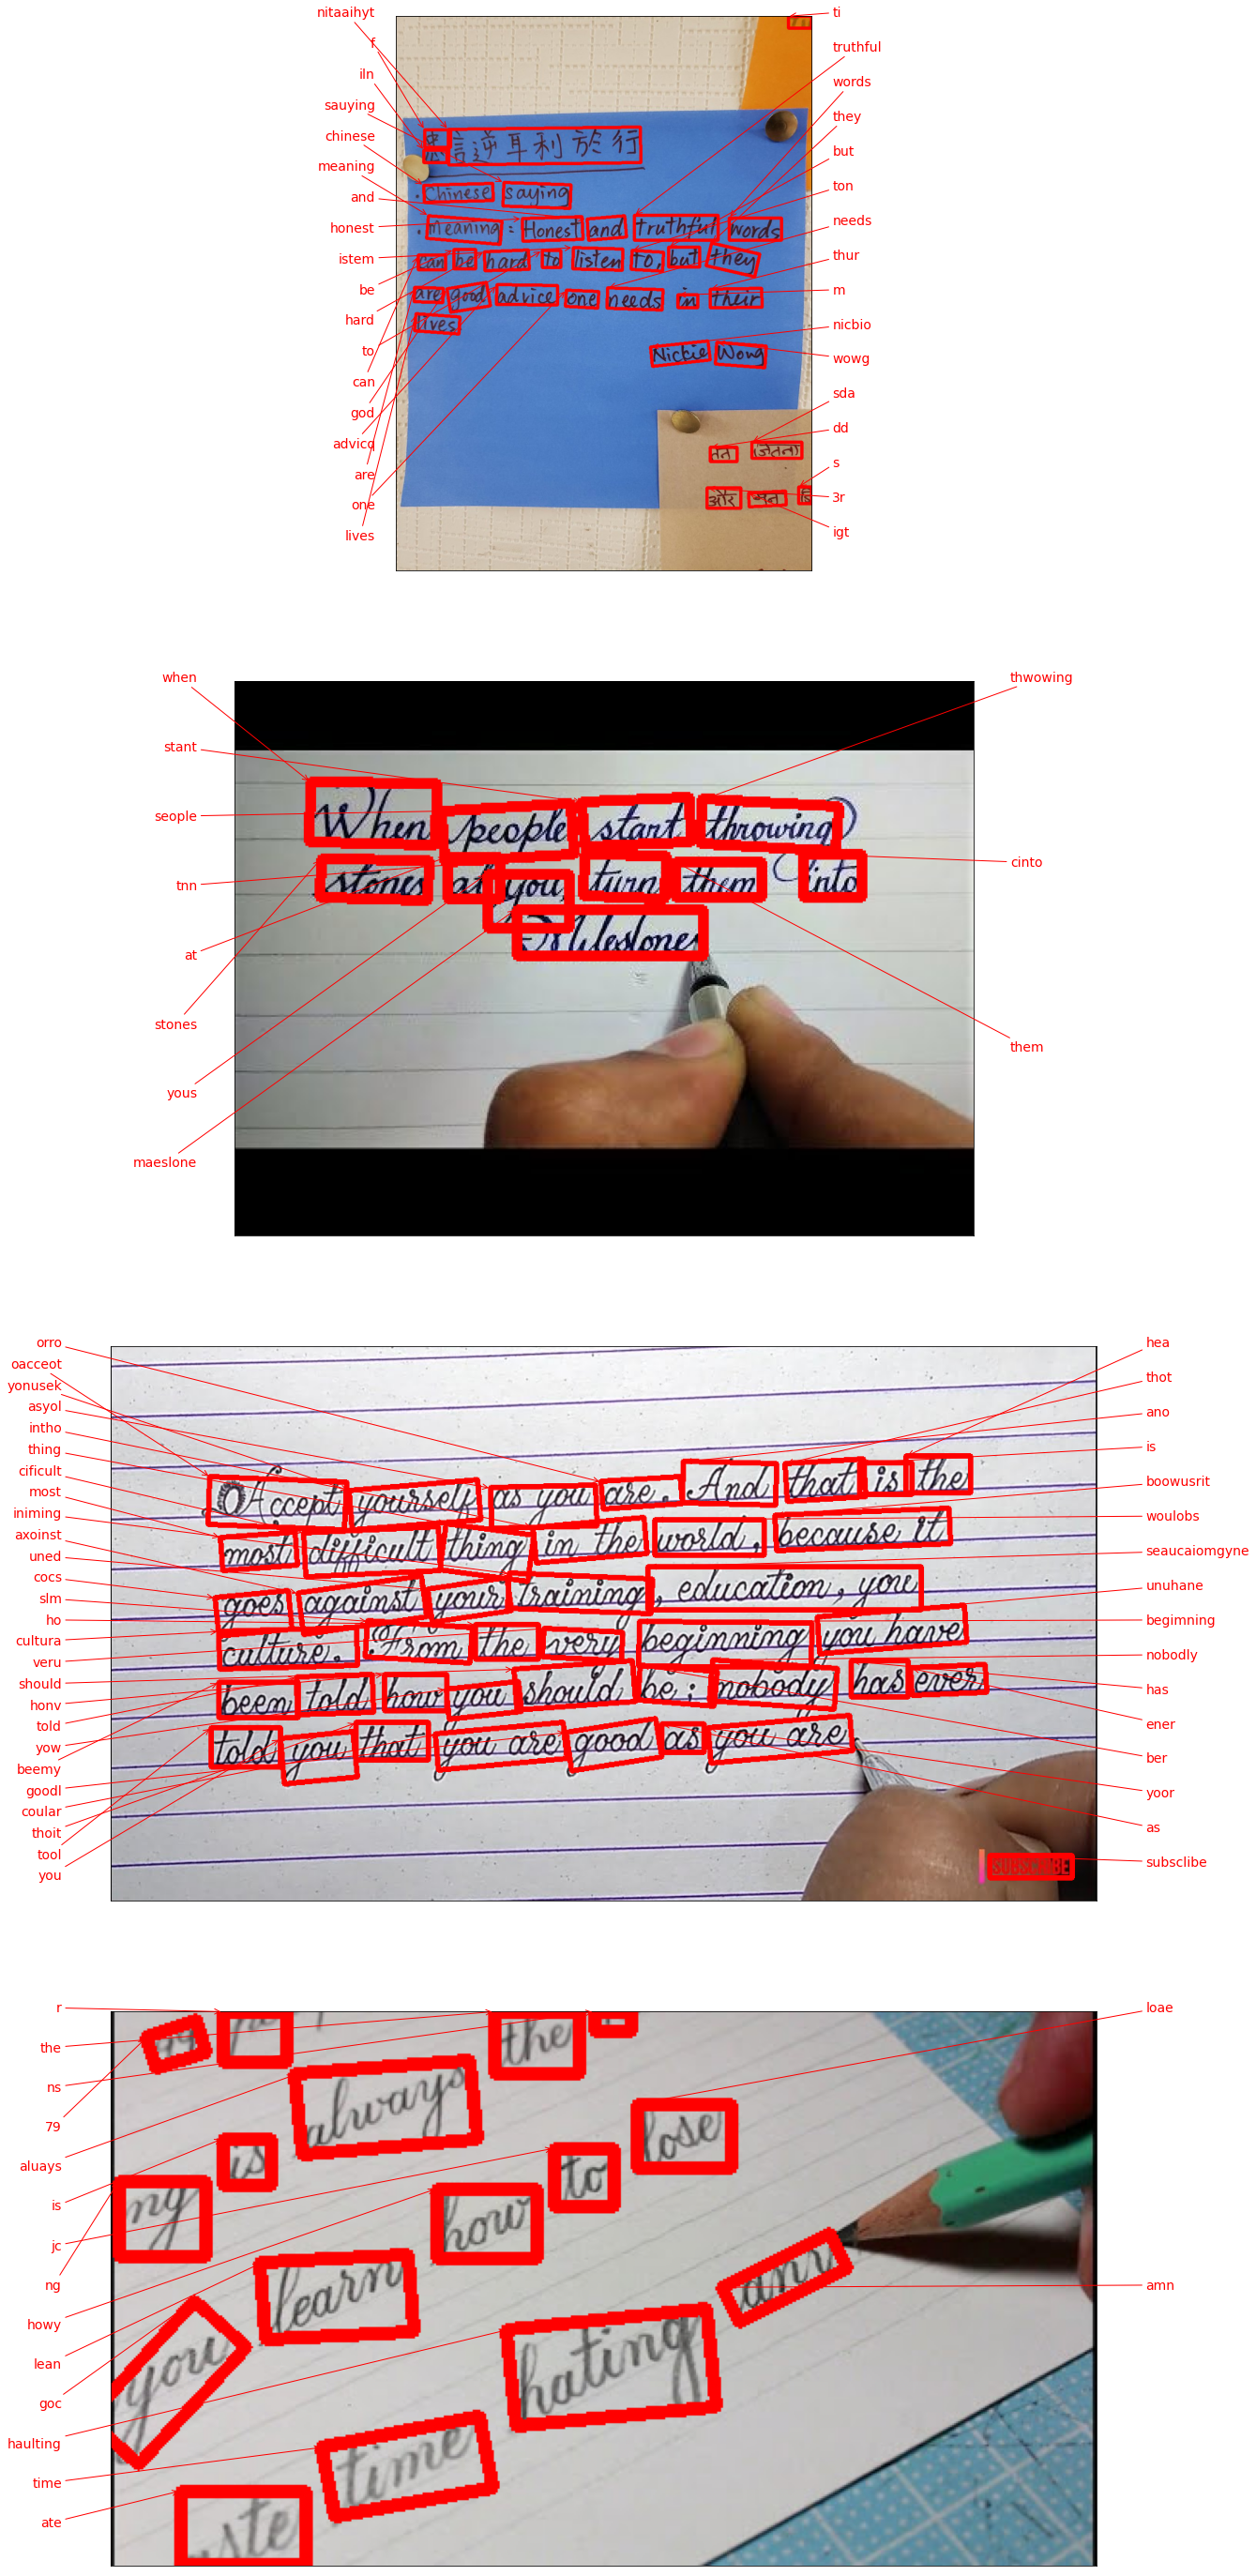

In [43]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(imgs), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=imgs[idx], 
                                    predictions=pred[idx][0], ax=ax)

# 3. Tesseract

In [33]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/handwriting_Kor/7_img'

img_file_path = '/home/aiffel/aiffel/ocr_python/handwriting_Kor/7.jpg'
#                 '/home/aiffel/aiffel/ocr_python/handwriting_Eng/2.jpg',
#                 '/home/aiffel/aiffel/ocr_python/handwriting_Eng/3.jpg',
#                 '/home/aiffel/aiffel/ocr_python/handwriting_Eng/4.jpg']#테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0000.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0001.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0002.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0003.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0004.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0005.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0006.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0007.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0008.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0009.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0010.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0011.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0012.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0013.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0014.png
/home/aiffel/aiffel/ocr_python/handwriting_Kor/7_img/0015.png
/home/ai

In [49]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

^ _^'벼

"


31

0\

년

01

=

여

그

낭.

소.

^

|

능

내:

선.

는

들

91해

731

소

주.

~

등.

7

작

재

스

겹

습니다.

또트5

71\

즉

도

71

글 씨드

느니

전말.

늦

갑

시!

716

느데어!

Done


# Step3. 테스트 결과 정리
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

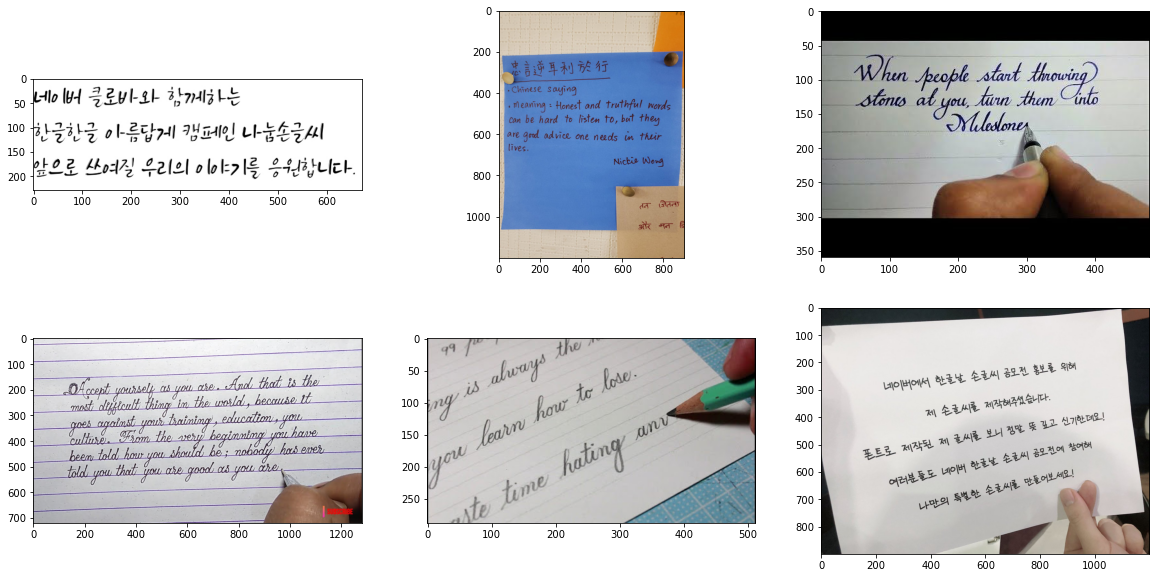

In [44]:
# 세 모델에 썼던 사진들을 모아봤다.
plt.figure(figsize=(20, 10))
img_list=['/home/aiffel/aiffel/ocr_python/handwriting_Kor/1.jpg',
    '/home/aiffel/aiffel/ocr_python/handwriting_Eng/1.jpg',
    '/home/aiffel/aiffel/ocr_python/handwriting_Eng/2.jpg',
    '/home/aiffel/aiffel/ocr_python/handwriting_Eng/3.jpg',
    '/home/aiffel/aiffel/ocr_python/handwriting_Eng/4.jpg',
    '/home/aiffel/aiffel/ocr_python/handwriting_Kor/7.jpg' 

    
]
for i in range(6):
    plt.subplot(2, 3, i+1)
    pil_img = Image.open(img_list[i])
    plt.imshow(pil_img)
plt.show()

# 1. google OCR API

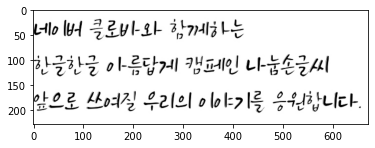

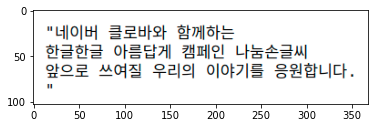

In [35]:
naver_clova = ['/home/aiffel/aiffel/ocr_python/handwriting_Kor/1.jpg',
              '/home/aiffel/Pictures/Screenshot from 2021-03-19 00-54-43.png']

for i in range(2):
    pil_img = Image.open(naver_clova[i])
    plt.imshow(pil_img)
    plt.show()

# 2. keras-ocr


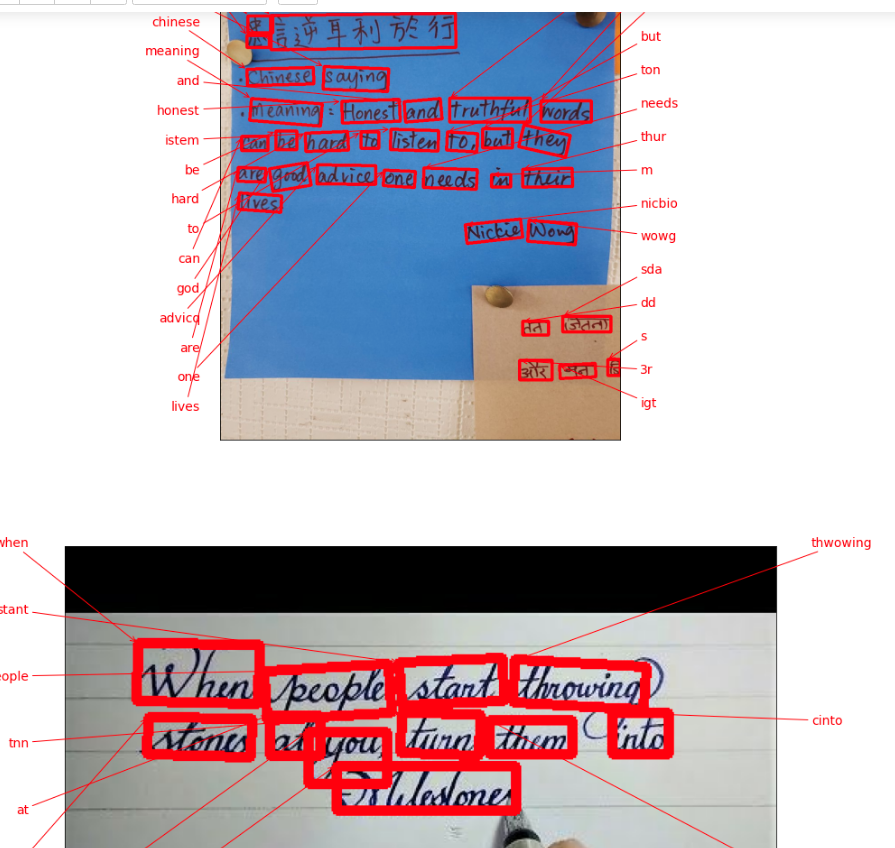

# 3. tesseract

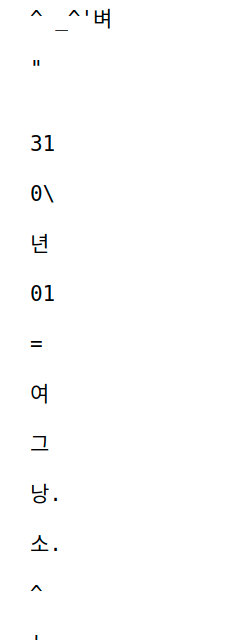

# Step4. 결과 분석과 결론 제시
- 우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
- 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시합니다.
- 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

--------------------------------------
손글씨를 디지털화해야하는 상황이나, 손글씨를 인식하지 못하는 경우(장애나 문맹,노안 등)에 필요한 서비스를 구현하고자 했다.
따라서 이 서비스는 어느정도 가독성 있고 일관되게 어떤 글씨체에서든 인식할 수 있어야 한다. 
각 세 모델을 평가하자면,
- google OCR- 굉장히 안정적으로 한국어를 인식하였다.
- keras-ocr - 영어의 현대적인 문체엔 어느 정도 인식하였으나, 필기체엔 쥐약인 모습을 보였다
- tesseract - 도저히 뭘 인식한 것인지 모르겠다.
따라서 google OCR을 선택할 것이다. 한국어도 인식을 잘 한다면, 영어에도 안정적인 모습을 보여줄 것이라 보기 때문이다.
keras-ocr, tesseract는 한국어이든 영어이든 인식률이 떨어지므로 선택하지 않겠다.